# Highly Parameterized Inversion

The current tutorial continues where the "freyberg glm part1" notebook left off. The "freyberg intro to model" and "freyberg pstfrom pest setup" provide details on the model and PEST dataset. The "freyberg glm 1" notebooks introduced changes to the PEST setup that are relevant to the current tutorial. You do not need to know the details of all these noteboks to follow along with general points of the current tutorial - but it helps! 

In this tutorial we will add the final tweaks to a PEST dataset and then calibrate our model using PEST++GLM. Much like PEST, PEST++GLM undertakes highly parameterized inversion. However, it streamlines alot of the user-input process. It also automates FOSM and FOSM-based Monte Carlo uncertainty analyses. This drastically reduces requirements for user input, making workflows easier to implement. However, it also increases the number of moving pieces that a user must be familiar with (no free lunch!).

Here we will discuss some PEST++GLM specific options and their implications, calibrate the model and then explore outputs - all using a programatic interface. 

### 1. Admin

Start off with the usual loading of dependencies and preparing model and PEST files. We will be continuing to work with the MODFLOW6 modified-Freyberg model (see "freyberg intro to model" notebook), and the high-dimensional PEST dataset prepared in the "freyberg glm 1" notebook. For the purposes of this notebook, you do not require familiarity with previous notebooks (but it helps...). 

Simply run the next few cells by pressing `shift+enter`.

In [36]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import matplotlib.pyplot as plt;
import shutil 

import sys
sys.path.append(os.path.join("..", "..", "dependencies"))
import pyemu
import flopy

sys.path.append("..")
import herebedragons as hbd

Specify the path to the PEST dataset template folder:

In [37]:
# specify the temporary working folder
t_d = os.path.join('freyberg6_template')

Copy across pre-prepared model and PEST files:

In [38]:
org_t_d = os.path.join("master_glm_1")
if not os.path.exists(org_t_d):
    raise Exception("you need to run the '/part2_glm/freyberg_glm_1.ipynb' notebook")

if os.path.exists(t_d):
    shutil.rmtree(t_d)
shutil.copytree(org_t_d,t_d)

'freyberg6_template'

In [39]:
pst_path = os.path.join(t_d, 'freyberg_pp.pst')

# a check to make sure the files exist
if not os.path.exists(pst_path):
    raise Exception("you need to run the '/part2_glm/freyberg_glm_1.ipynb' notebook")

Right then, let's load in our PEST control file.

Just as a reminder, this is the control fle prepared in the "glm 1" notebook:
 - We have reduced our very high dimensional PEST dataset down from 10s of thousands to several hundreds of parameters (#sad).
 - We continue to have lots of spatially distributed parameters (pilot points), which we expect to have a degree of spatial (and in some cases, temporal) correlation. 
 - We have weighted observations to reflect the inverse of measurement noise standard deviation. 
 - We have already calculated a Jacobian matrix, with parameter sensitivities based on intial parameter values. It is stored in a file named "freyberg_pp.jcb".


In [40]:
pst = pyemu.Pst(pst_path)

In [41]:
# check to see if obs&weights notebook has been run
if not pst.observation_data.observed.sum()>0:
    raise Exception("You need to run the '/part2_obs_and_weights/freyberg_obs_and_weights.ipynb' notebook")

In [42]:
print(f'number of observations: {pst.nnz_obs} \nnumber of parameters: {pst.npar_adj}')

number of observations: 144 
number of parameters: 415


### 2. Regularisation

We have more unkown parameters than observations. Thus, we have an ill-posed inverse problem. The mathematical term for the process through which a unique solution is sought for a nonunique inverse problem is “regularisation”. The goal of regularised inversion is to seek a unique parameter field that results in a suitable fit between model outputs and field measurements, whilst minimizing the potential for wrongness in model predictions. That is, out of all the ways to fit a calibration dataset, regularized inversion seeks the parameter set of minimum error variance.

There are two main approaches used to stabilize this problem: 
 1) adding soft knowledge and/or 
 2) reducing the problem dimensionality. 

These methods can be used by themselves, but are most commonly applied together.

#### 2.1. Tikhonov Regularisation (e.g. "soft knowledge")

One way to seek a parameter field of minimum error variance is to seek a parameter field that allows the model to fit the calibration dataset, but whose values are also as close as possible to a set of “preferred parameter values”. Ideally, preferred parameter values should also be initial parameter values as listed in the “parameter data” section of the PEST control file. These preferred parameter values are normally close to the centre of the prior parameter probability distribution. At the same time, scales and patterns of departures from the preferred parameter set that are required for model outputs to fit a calibration dataset should be achieved in ways that make “geological sense”.

PEST provides a user with a great deal of flexibility in how Tikhonov constraints can be introduced to an inversion process. The easiest way is to do this is through the use of prior information equations. When prior information equations are employed, Tikhonov constraints are expressed through preferred values that are assigned to linear relationships between parameters. (Equality is the simplest type of linear relationship.) Weights must be assigned to these equations. As is described in PEST documentation, when PEST is run in “regularisation” mode, it makes internal adjustments to the weights that are assigned to any observations or prior information equations that belong to special observation groups that are referred to as “regularisation groups”. 


#### 2.2. Promoting "Geologicaly Reasonable" Patterns

PEST (and PEST_HP) provide the option to replace prior information equation weights with covariance matrices. When prior information equations embody Tikhonov constraints, they can be used to ensure that patterns of parameter heterogeneity that emerge from the inversion process are geologically reasonable. (See the GMDSI Tutorials for examples of how to accompish this with PEST_HP: https://gmdsi.org/blog/calibration-a-simple-model/)

PEST++GLM (which we will be using here) does things a bit differently. You *can* specify prior information equations and assign relevant weights and run PEST++GLM in "regularisation" mode. (See the "intro to pyemu" notebook for an example of how to specify prior information equations.) However, PEST++GLM does not accept covariance matrices for the purposes of specifying preferred parameter heterogeneity.

Alternatively, PEST++GLM offers users the option of using prior parameter covariance matrix based regularisation directly in the parameter upgrade calculation process - referred to as Regularized-Gauss-Levenburg-Marquardt. Instead of using the contribution of regularisation to the objective function to avoid "unrealistic" parameter patterns (as is done in PEST), this approach tries to maintain "realistic" patterns directly when calculating parameter upgrades. 

As we will show further on, this is implemented by specifying a prior parameter covariance matrix and the relevant `pest++` options. If this option is enabled, then prior information equation based regularisation cannot also be employed. Regularisation is controlled by the max singular values and eigen threshold control variables in the SVD section.

Pragmatically, the latter approach is the easier one to implement within a PEST++ workflow. A modeller will likley have already prepared a prior parameter covariance marix (we have uncertianty on our mind after all...). Thus, only a few lines need to be added to the PEST control file. It also removes the need to determine and dynamically adjust prior information weights, making the process numerically more efficient. 

The Regularized-Gauss-Levenburg-Marquardt option is activated with the `glm_normal_form(prior)` pest++ option and by providing a prior parameter covariance matrix in `parcov()`.

Let's start by preparing this covariance matrix. Recall that we created a prior covariance matrix in the "freyberg pstfrom pest setup" tutorial and saved it in a file named "prior_cov.jcb". That matrix contains values for *all* the parameters. First, we need to reduce it down to only the adjustable parameters in our current "pilot points" control file:

In [43]:
# read the orginal high-dimensional covariance matrix
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))

# reduce it down to the currently adjustable parameters
cov = cov.get(pst.adj_par_names)

# write the reduced covariance matrix to an external file
cov.to_ascii(os.path.join(t_d,"glm_prior.cov"))

Now that the covariance matrix is ready, let's add the pest++ control variables to the `pst` control file.

Start by providing the control variable specifying the filename for the prior parameter covariance matrix. This matrix is used for both regularisation and during FOSM:

In [44]:
# specify the prior parameter covariance matrix file
pst.pestpp_options["parcov"] = "glm_prior.cov"

Then specify the option to employ Regularized-Gauss-Levenburg-Marquardt:

In [45]:
# activate the regularized-GLM solution
pst.pestpp_options["glm_normal_form"] = "prior"

Boom! Done.

### 2.3. SVD

Tikhonov regularisation adds information to the calibration process in order to achieve numerical stability. In contrast, subspace methods do so by reducing the dimensionality of the problem, removing and/or combining prameters. When employing SVD in calibration, only parameters and linear combinations of parameters that are suficiently constrained by measured data are estimated. These parameters are said to reside in the *solution space*. Chossing which parameter combinations to estimate is accomplished via singular value decomposition (SVD). SVD-based parameter estimation fixes intial values for parameters/parameter combinations that are not estimable (reside in the *null space*) and does not adjust them during inversion. (So make sure initial parameter values are sensible!)  

Unlike PEST, by default members of the PEST++ suite employ singular value decomposition (or methods closely related to it) for solution of the inverse problem. Unless otherwise specifed, default options are employed. PEST++GLm offers two numerical libraries for implementing SVD; the default option will usually suffice (see the manual for details).

Two variables affect how SVD is deployed: MAXSING and EIGTHRESH. These are recorded in the `* singular value decomposition` section of the PEST control file. By default, MAXSING is equal to the number of adjustable parameters and EIGHTRESH is 1.0E-7. 

When employing Regularized-Gauss-Levenburg-Marquardt (i.e. if the `glm_normal_form(prior)` option is specified, as we have done here), the values of MAXSING and EIGTHRESH control the degree of regularisation. 

For the purposes of this tutorial, we will use default values. However, if desired, these variables could be assigned thus:

In [46]:
# MAXSING
pst.svd_data.maxsing = pst.npar_adj

#EIGTHRESH
pst.svd_data.eigthresh = 1e-7

### 2.4. SVD-assist

Use of PEST’s “SVD-assist” methodology can promulgate significant increases in the numerical efficiency of highly parameterized inversion. In implementing this methodology, PEST estimates the values of so-called “super parameters” in place of the parameters themselves. 

Estimating super parameters can reduce the computational cost of highly parameterized inversion considerably. However, a Jacobian matrix based on the full parameter set must be calculated before the super parameter inversion process.

We have already done so in the "freyberg glm 1" tutorial. We can now make use of the pre-calculated Jacobian matrix to save time. We specify this with the `base_jacobian` pest++ option. Note that this is **not** an SVD-Assist specific option. It can be used any time.

In [47]:
# make a copy of the Jacobian file with a different name
shutil.copy2(os.path.join(t_d,"freyberg_pp.jcb"),
             os.path.join(t_d,"freyberg_reuse.jcb"))

'freyberg6_template\\freyberg_reuse.jcb'

In [48]:
# specify file to use as the base jacobian
pst.pestpp_options["base_jacobian"] = "freyberg_reuse.jcb"

Unfortunately, the large computational savings gained from SVD-assisted inversion come with a number of costs. Chief among these is that, for a nonlinear model, the partitioning of parameter space into solution and null spaces based on singular decomposition of a full Jacobian matrix calculated on the basis of initial parameter values may not remain valid as parameter values change. Hence, as the super parameter inversion process progresses, it may become necessary to recalculate a full Jacobian matrix so that super parameters can be re-defined. 

For moderately to highly nonlinear models, super parameter redefinition may be required every few iterations. With intermittent super parameter redefinition, model run savings accrued through SVD-assisted inversion may still be considerable; however, they will not be as great as for a linear model where re-computation of a full Jacobian matrix is never required.

In PEST++GLM, the `n_iter_base` and `n_iter_super` pestpp options determine the number of sequential base and super parameter iterations, respectively. Choosing values for these variables will be case specific and may require some trial and error. Relatively linear problems may work well a single base iteration. Non liner problems will likley benefit from fewer super iterations, interspersed with base iterations. Ideal values may also depend on the maximum number of super parameters (discussed further on).

For our case we have found that a single base parameter iteration, followed by a few super iterations is sufficient. 

In [49]:
# for convenience, specify a maximum number of iterations. Avoids wasting cpu-time for the purposes of the tutorial; in the real-world you will probably use more than this
pst.control_data.noptmax = 6

# specify the number of base parameter iterations; 
# by passing a value of -1, PEST++GLM will calculate a single iteration and then switch to super parameter iterations
pst.pestpp_options["n_iter_base"] = -1

# specify the number of subsequent super parameter iterations; set equal to NOPTMAX
pst.pestpp_options["n_iter_super"] = pst.control_data.noptmax

The number of super parameters determines the number of model runs undertaken during a super parameter iteration. The number of super parameters to estimate can be set using either or both of the `max_n_super()` and ­`super_eigthresh()` pest++ control variable.  The upper limit of super parameters to form is controlled by `max_n_super()`. Ideally, this value should be as high as possible. In practice, it may have to reflect available computational resources. (See the PEST Manual Part 1 for a pragmatic discussion of how to choose the number of super parameters.) 

For our case, through a bit of trial-and-error we know reasonable results can be achieved with a maximum of super parameters specified in the following cell. That's already a decent amount of savings in terms of run-time! Now, for each iteration instead of running the model several hundred times (i.e. the number of adjustable base parameters; see `pst.npar_adj`) we only need to run the model a few tens of times. An order of magnitude less!

In [50]:
pst.pestpp_options["max_n_super"] = 60


### 2.5. FOSM
 

PEST++GLM makes FOSM parameter and predictive uncertainty analysis a breeze. 

At the end of each iteration PEST++GLM implements FOSM analysis, as long as the `uncertainty()` control variable is set to `true` (it is by default). If present, it ignores regularisation and prior information equations (not present in our case). By default, prior parameter uncertainties are calculated from parameter bounds. Alternatively, a user can supply a prior parameter covariance matrix with the `parcov()` variable; this permits inclusion of prior parameter covariances. Recall that we have already specified this option: 

In [51]:
pst.pestpp_options['parcov']

'glm_prior.cov'

PEST++GLM calculates a posterior parameter covariance matrix at the end of each iteration. Each covariance matrix is recorded in an extenral file. PEST++GLM also provides summaries of prior and posterior parameter uncertainties (means, standard deviations and bounds) for each iteration.

If any observations are listed as forecasts (in the `forecast()` variable), PEST++GLM will also undertake predicitve uncertainty analysis. By default, if no forecasts are provided, PEST++GLM will assume all zero-weighted observations are forecasts - so it is usually a good idea to specify forecasts explicitly (if you have many many zero-weighted obsevrations FOSM can cost some computation time). Recall that we specifed several observations as forecasts:

In [52]:
pst.pestpp_options['forecasts']

'oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time'

FOSM implemented by PEST++GLM assumes that the standard deviation of measurement noise associated with each observation is proportional current observation residual. This accounts for the model's ability to reproduce an obsevration. Effectively, it assumes that the residual is a measure of measurement noise + model error. Thus, observation weights used during FOSM are calcualted as the inverse of the residual. Note that this "residual weight" never increases weights beyond those which are specified in the control file! The assumption is that weighs in the control file represent the inverse of measurment noise standard deviation - and it would be illogical to decrease noise beyond this level. 

It is important to keep this in mind. If observation weights in the control file do **not** represent measurement noise, then it may be preferable to not use PEST++GLM to undertake FOSM during parameter estimation. In our case, weights represent the inverse of measurment standard deviations - so we are all good!

### 2.6. FOSM-informed Monte Carlo

PEST++GLM also has the ability to undertake nonlinear Monte Carlo uncertainty analysis. FOSM-based posterior Monte Carlo (also called Bayes-linear Monte Carlo) is implemented by drawing samples of parameters from the posterior parameter distribution (described by the posterior parameter covariance matrix and assuming best-fit parameter values as the mean). Each of these parameter realisation is then simulated. As long as forecasts are included as observations in the control file, then the Monte Carlo process provides an ensemble of forecast values. With enough samples of foreacast the posterior predictive uncertainty can be described. In principle, using FOSM-based Monte Carlo to evaluate forecast uncertainty relaxes the assumption of linearity between and foreacsts and parameters - making it more robust.

Activating this option is as easy as adding the `glm_num_reals()` option to the control file and specifying the number of Monte Carlo realisation to sample: 

In [53]:
pst.pestpp_options["glm_num_reals"] = 50

### 2.7. Extra Utility Options

There are numerous "utility" options availabel in PEST++GLM. The user manual provides descriptions of all of them. The following two specify options for halting PEST++GLM due to model-run failure:

In [54]:
# consider a model to have failed if it takes 5 times the average model run time
pst.pestpp_options["overdue_giveup_fac"] = 5.0
# attemp to repeat a failed model a maximum of 3 times; if it still fails, halt PEST++
pst.pestpp_options["max_run_fail"] = 3

### 2.7. Re-write Control File and Run PEST++GLM

Re-write the control file with the updated pestpp options.

In [55]:
# write PST 
case = 'freyberg_pp'
pst.write(os.path.join(t_d,f"{case}.pst"))

noptmax:6, npar_adj:415, nnz_obs:144


Now, deploy PEST++GLM in parallel.

To speed up the process, you will want to distribute the workload across as many parallel agents as possible. Normally, you will want to use the same number of agents (or less) as you have available CPU cores. Most personal computers (i.e. desktops or laptops) these days have between 4 and 10 cores. Servers or HPCs may have many more cores than this. Another limitation to keep in mind is the read/write speed of your machines disk (e.g. your hard drive). PEST and the model software are going to be reading and writting lots of files. This often slows things down if agents are competing for the same resources to read/write to disk.

The first thing we will do is specify the number of agents we are going to use.

# Attention!

You must specify the number which is adequate for ***your*** machine! Make sure to assign an appropriate value for the following `num_workers` variable:

In [56]:
# run glm in parallel
num_workers = 5
m_d = os.path.join('master_glm_2')
pyemu.os_utils.start_workers(t_d,"pestpp-glm",f"{case}.pst",
                           num_workers=num_workers,
                           worker_root=".",
                           master_dir=m_d)

To see PEST++'s progress, switch to the command line window from which you launched this notebook. Wait until it has completed. This may take several minutes. Feel free to go make a cup of coffee.

### 3. Postprocess

During inversion PEST++ records a lot of usefull information in external files. We shall not go through each of these here (see the PEST++ user manual for detailed descriptions). The following are some common outputs a modeller is likely to inspect.


A usefull way to track PEST's performance is to look at the evolution of Phi throughout the inversion. This is recorded in a file with the extension `*.iobj`  (e.g. `freyperg_pp.iobj`). You can read this file whilst PEST++ is working if you like. PEST++ will update the file after every iteration, thus it provides an easy way to keep an eye on the inversion progress.

The file has a tabular format, making it easy to read as a `Pandas` dataframe:

In [57]:
# make a dataframe "df_obj" that shows the contents of the pst file casename with the extension .iobj
# .iobj = PEST++ output file that has the objective function by iteration 
df_obj = pd.read_csv(os.path.join(m_d, "freyberg_pp.iobj"),index_col=0)
# echo out the dataframe
df_obj.head()

,model_runs_completed,total_phi,measurement_phi,regularization_phi,cum,oname:cum_otype:lst_usecol:in-out,oname:cum_otype:lst_usecol:percent-discrepancy,oname:cum_otype:lst_usecol:rcha,oname:cum_otype:lst_usecol:sfr,oname:cum_otype:lst_usecol:sto-ss,...,oname:inc_otype:lst_usecol:sto-sy,oname:inc_otype:lst_usecol:total,oname:inc_otype:lst_usecol:wel,oname:sfr_otype:lst_usecol:gage-1,oname:sfr_otype:lst_usecol:headwater,oname:sfr_otype:lst_usecol:tailwater,oname:sfrtd_otype:lst_usecol:gage-1,oname:sfrtd_otype:lst_usecol:headwater,oname:sfrtd_otype:lst_usecol:tailwater,part
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,257.3280,257.3280,0,0,0,0,0,0,0,...,0,0,0,29.09590,0,0,16.20940,0,0,0
1,11,157.3760,157.3760,0,0,0,0,0,0,0,...,0,0,0,12.05290,0,0,7.20769,0,0,0
2,82,125.7920,125.7920,0,0,0,0,0,0,0,...,0,0,0,22.54350,0,0,5.04338,0,0,0
3,153,138.1210,138.1210,0,0,0,0,0,0,0,...,0,0,0,11.50480,0,0,5.83726,0,0,0
4,284,62.9861,62.9861,0,0,0,0,0,0,0,...,0,0,0,6.15844,0,0,2.48718,0,0,0


A quick and dirty plot to see the evolution of Phi per iteration. Ideally Phi should decrease for each sucessive iteration. If this plot bounces up and down it is often a sign of trouble. When using SVD-Assist, this often occurs if the inverse problem is highy nonlinear. In such cases it may be worth experimenting with fewer sucessive super parameter iterations and/or a greater number of super parameters. 

array([<AxesSubplot:xlabel='iteration'>, <AxesSubplot:xlabel='iteration'>],
      dtype=object)

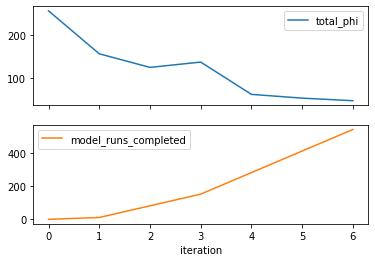

In [58]:
# plot out the dataframe that was shown as a table above
df_obj.loc[:,["total_phi","model_runs_completed"]].plot(subplots=True)

### 3.1. Residuals

We may also wish to compare the measured versus simulated observation values obtained using the "best-fit" parameter set.

PEST++ stores obsevration residuals in a `*.rei` file. When instantiating a `Pst` class from an existing control file, `pyemu` will attemp to read a corresponding `*.rei` file. Data from the rei file is stored in the `Pst.res` attribute as a `Pandas` `DataFrame`. This makes it easy to access and postprocess. We can also read in residuals after instatinating a `Pst` object by using the `Pst.set_res()` method. 

In [59]:
pst.set_res(os.path.join(m_d, 'freyberg_pp.rei'))

And then display 1-to-1 and residual plots for each of the non-zero weighted observation groups. This is a quick way to explore how well the model is able to replicate measured data.

These plots you'll see often.  The left plot is a "1:1" plot that has simulated values on the x-axis and measured values on the y-axis; a perfect fit would be all circles on the black diagonal line.  

The right plot has the residual (y-axis) compared to the observation magnitude (x-axis).  The closer the circle is to the black line the better the fit.  The mean residual is shown as a red line. Ideally this red line should plot on y=0. 

Scroll down through the plot below. How well does the model replicate historical data? Within the range of "measurement error"? Seems good overall!

What about the residuals? are they evenly distributed around zero? No? Oh dear. This is a sign of bias. It means there is somethign wrong with the model or with the assumptions used for history matching. (In fact, because this is a synthetic model, we know what the cause is: under-parameterisation. Recall all the grid and pilot point parameters that we set as "fixed" during the "glm part 1" tutorial.) By looking for a "good" fit with our poor model, we may be inducing bias in our predictions. Perhaps we would be better served by accepting a worse fit...let's look at our forecasts.

<Figure size 576x756 with 0 Axes>

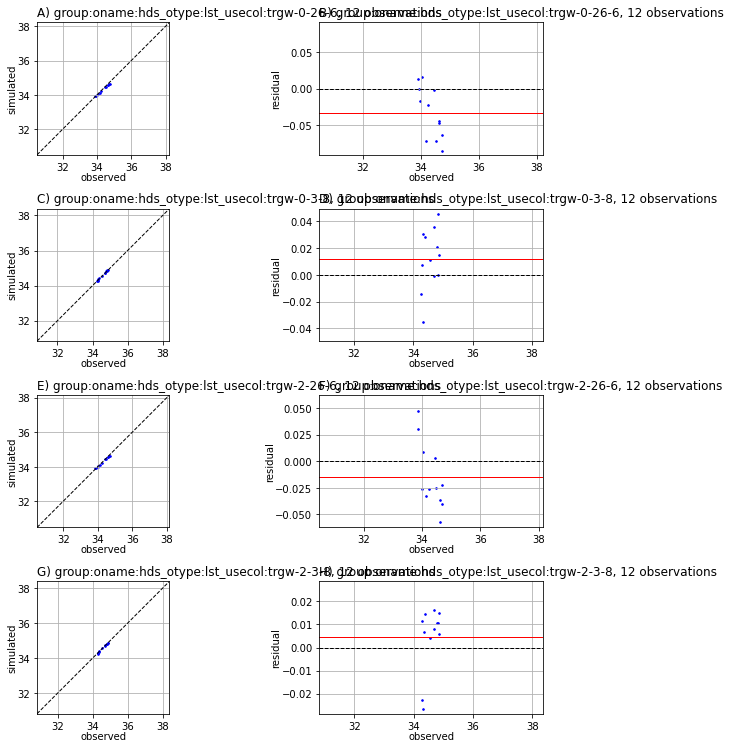

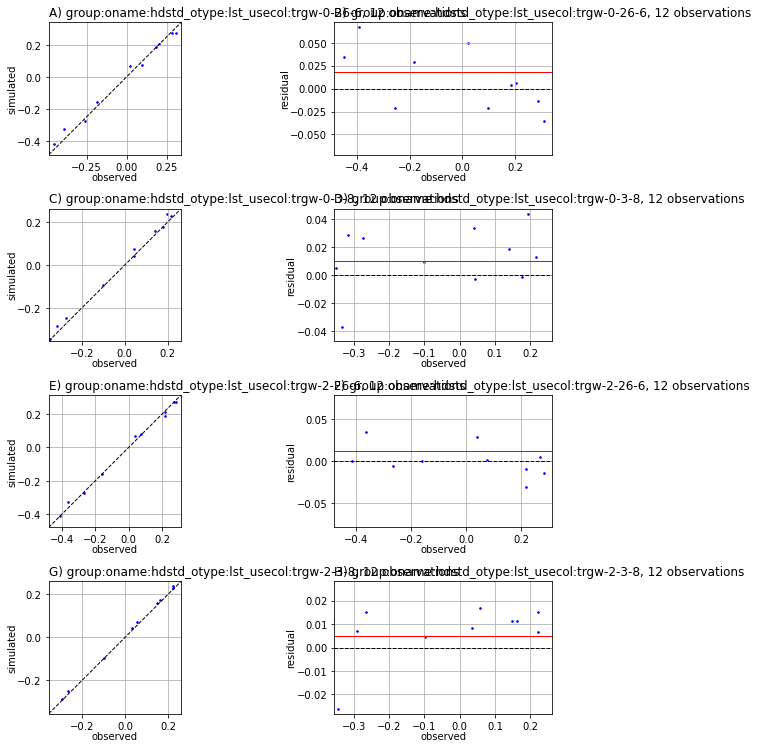

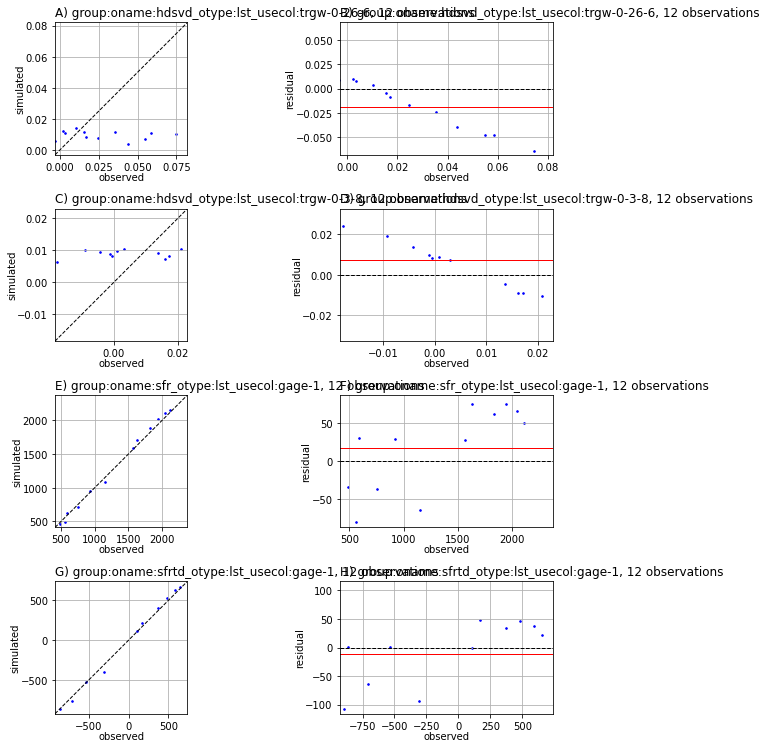

In [60]:
# use pyemu's plot utilities to plot 1:1 line and the residuals as fxn of observation magnitude
pyemu.plot_utils.res_1to1(pst);

### 3.2. Posterior Monte Carlo 

Because we included FOSM-based Monte Carlo options in the control file, when PEST++GLM concluded the inversion, it subsequently simulated an ensemble of parameters sampled from the linearized posterior parameter probability distribution. Observations from these simulations are recorded in the file named `freyberg_pp.post.obsen.csv`.
Let's read this file and instantiate a `pyemu.ObservationEnsemble` object to make it easy to plot them:

In [61]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

oe.head()

,oname:cum_otype:lst_usecol:ghb_totim:3652.5,oname:cum_otype:lst_usecol:ghb_totim:3683.5,oname:cum_otype:lst_usecol:ghb_totim:3712.5,oname:cum_otype:lst_usecol:ghb_totim:3743.5,oname:cum_otype:lst_usecol:ghb_totim:3773.5,oname:cum_otype:lst_usecol:ghb_totim:3804.5,oname:cum_otype:lst_usecol:ghb_totim:3834.5,oname:cum_otype:lst_usecol:ghb_totim:3865.5,oname:cum_otype:lst_usecol:ghb_totim:3896.5,oname:cum_otype:lst_usecol:ghb_totim:3926.5,...,oname:sfrtd_otype:lst_usecol:tailwater_time:4169.5,oname:sfrtd_otype:lst_usecol:tailwater_time:4199.5,oname:sfrtd_otype:lst_usecol:tailwater_time:4230.5,oname:sfrtd_otype:lst_usecol:tailwater_time:4261.5,oname:sfrtd_otype:lst_usecol:tailwater_time:4291.5,oname:sfrtd_otype:lst_usecol:tailwater_time:4322.5,oname:sfrtd_otype:lst_usecol:tailwater_time:4352.5,oname:sfrtd_otype:lst_usecol:tailwater_time:4383.5,part_status,part_time
real_name,,,,,,,,,,,,,,,,,,,,,
0,-1263830.0,-1276180.0,-1291880.0,-1310080.0,-1326560.0,-1340320.0,-1351710.0,-1359080.0,-1363700.0,-1366510.0,...,-97.429,29.9258,144.0150,239.982,273.124,311.803,261.295,58.7243,5,33645.8
1,-2258280.0,-2277980.0,-2299960.0,-2323990.0,-2346590.0,-2367590.0,-2384180.0,-2396910.0,-2406080.0,-2412580.0,...,117.113,235.9780,366.8930,485.971,528.115,485.962,371.521,203.1520,3,198386.0
2,-1405720.0,-1420150.0,-1436410.0,-1458340.0,-1479350.0,-1497820.0,-1512730.0,-1524850.0,-1533050.0,-1538460.0,...,-205.885,-41.9919,62.0151,176.893,222.392,214.711,117.082,-21.4966,3,344699.0
3,-1009890.0,-1019540.0,-1031420.0,-1045070.0,-1058050.0,-1069960.0,-1079750.0,-1086960.0,-1092510.0,-1096670.0,...,-241.929,-84.2777,92.6885,261.324,361.562,309.542,173.986,35.4300,2,164147.0
4,-1019340.0,-1029670.0,-1042990.0,-1058000.0,-1071560.0,-1083610.0,-1093630.0,-1100890.0,-1105050.0,-1106990.0,...,-144.222,-13.2485,126.8550,252.104,342.523,351.195,261.400,102.1630,5,143170.0


Let's plot a histogram of Phi achieved by this ensemble. Some have a good fit (low Phi). Others not so much. (The more linear the problem, the more likley that more will have a good fit.) So should we use all of them? Probably not.

<AxesSubplot:>

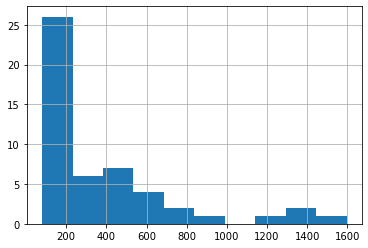

In [62]:
oe.phi_vector.sort_values().hist()

Theoretically, as observations were weighted with the inverse of the standard deviation of measurement noise, we should accept a Phi equal to the number of nonzero observations. In practice, because of model error, we rarely reach the ideal value of Phi. For the purposes of this tutorial, we are going to arbitrarily take the 30 best realisations and use these as our "posterior ensemble".

In [63]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:30],:] #just take the 30 lowest phi realizations

Most of our observations are time series. Let's take a look at how well time series from the ensemble of outputs match those of measured values. This allows us to get a quick look at where the ensmbles may not be capturing model behaviour well. 

Run the following cell to generate the plots. Each plot displays an obsevration time series. The red line are the measured values. The simulated values from each posterior realisation are displayed as blue lines.

Overall it doesn't look too bad, but we do see some more indications of potential problems. The posterior ensemble fails to cover some of the measured data. Noticeably, measured values (red line) tend to be near the limits of the posterior ensemble - they should be at the centre. This may be due to bias (see residual plots from earlier on) and/or under-estimation of uncertainty (too few realisations? too few parameters?).

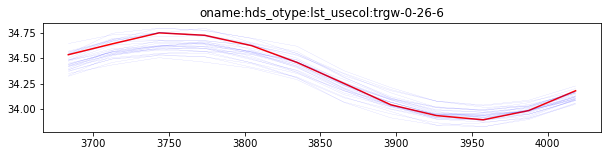

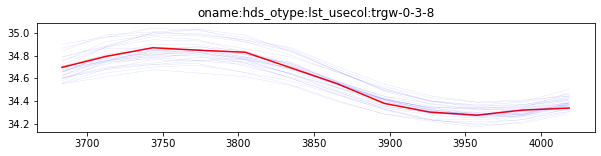

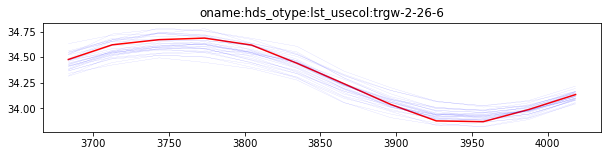

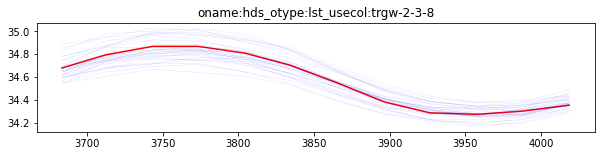

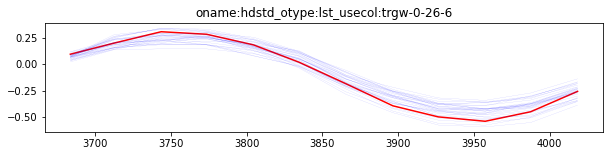

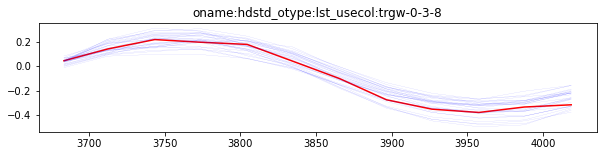

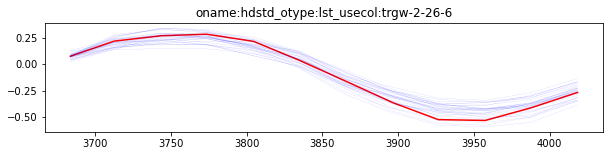

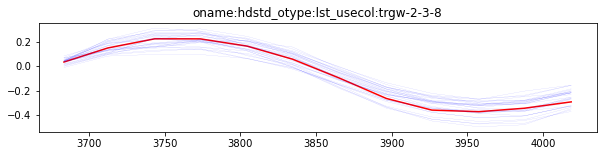

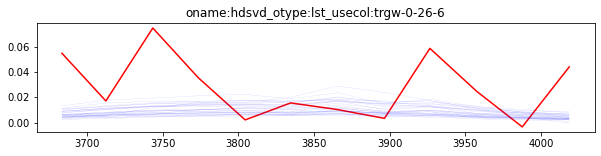

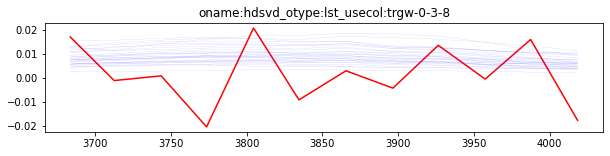

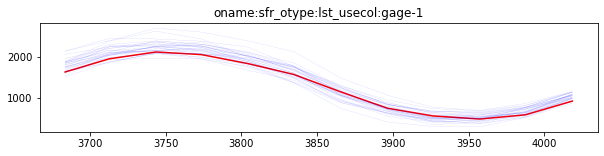

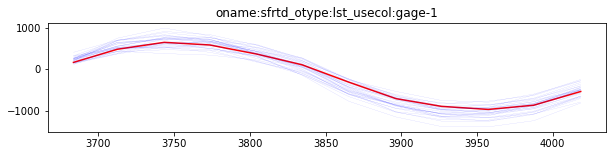

In [64]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()

for nz_group in pst.nnz_obs_groups:
    # select obs values
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    nz_obs_group.time = nz_obs_group.time.astype(float)
    nz_obs_group.sort_values('time', inplace=True)
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    # plot measured values
    ax.plot(nz_obs_group.time,nz_obs_group.obsval,"r-")
    # plot simulated values from post ensemble
    [ax.plot(nz_obs_group.time,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]

    ax.set_title(nz_group)
 
plt.show()

### 3.3. The Minimum Error Variance Parameter Field

We have inspected the models' ability to replicate measured data. It is also a good idea to inspect how "sensible" are the obtained parameter values. A common easy check is to visualy inspect the spatial distirbution of hydrualic property parameters. One can often find unexpected insight from how parameter patterns emerge during calibration. 

First start by updating the control file with the calibrated parameter values using the `Pst.parrep()` method:

In [65]:
pst.parrep(parfile=os.path.join(m_d, 'freyberg_pp.par'))

Updating parameter values from master_glm_2\freyberg_pp.par
parrep: updating noptmax to 0


Then write the parameter values to the model input files and run the model once:

In [66]:
# updates the model input files with parameter values
pst.write_input_files(pst_path=m_d)

# run the model forward run; this applies all the multipler paarameters, executes MODFLOW6 and MODPATH7 and then postprocess observations
pyemu.os_utils.run('python forward_run.py', cwd=m_d)

Now we can use `flopy` to load the model and plot some fo the parameters. For example, inspecting horizontal K:

[<AxesSubplot:title={'center':'k layer 1'}>,
 <AxesSubplot:title={'center':'k layer 2'}>,
 <AxesSubplot:title={'center':'k layer 3'}>]

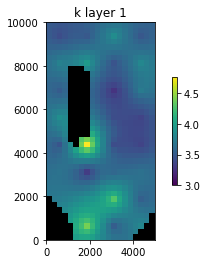

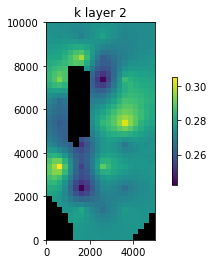

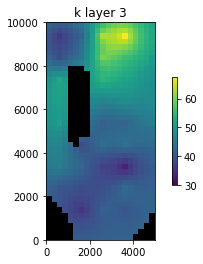

In [67]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=m_d, verbosity_level=0)
# load flow model
gwf = sim.get_model()
gwf.npf.k.plot(colorbar=True)
#gwf.sto.ss.plot()
#gwf.sto.sy.plot()

Looks a bit "blotchy", but not *too* bad...perhaps not particularily realistic, hey? In part, this is due to using the regularized Gauss Levenburg Marquardt option which tends to not look as "smooth" as using regularisation explicitly. 

What is more concerning are the localized areas of extreme parameter values, which may indicate parameters taking on compensatory roles - the plots of residuals and ensembles above hint at this as well. 

Another quick check is to look for parameters which are at their bounds. This is often a sign of an incorrect model setup or poor parameterisation. 

In [68]:
# idealy, this should return an empty list
pst.get_adj_pars_at_bounds()

([], ['pname:welcst_inst:9_ptype:cn_usecol:3_pstyle:m'])

Ooo - that is pretty bad. Many parameters at their bounds. It does provide a possible explanation for the blotchiness in the spatial distribution of K - local values of K are taking on surrogate roles to compensate for parameters at their bounds. A clear sign of either a strucutral problem with the model or poor parameterisation. 

Ideally, a modeller would now go back and try and correct this. For this tutorial, we will not do so. We *know* why this happend because we engineered it. (However, if you have the inclination, why not try and see if you can come up with a solution? hint: in the "glm part1" notebook we induced under parameterisation, in particular for recharge parameters.)

### 3.4. Forecast Uncertainty

So far we have looked at the fit with measured data. But what we are realy intersted in are the forecasts. We instructed PEST++GLM to undertake both FOSM and FOSM-based Monte Carlo uncertainty analysis.

We have alread loaded the ensemble of forecasts from the Monte Carlo analysis (`oe_pt`). Let's also load and plot the FOSM forecast results along side of the ensemble results. FOSM forecast results are recorded in the file named `freyberg_pp.pred.usum.csv`. 

In [69]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,34.810,0.496589,33.8168,35.8031,34.6261,0.208822,34.2085,35.0437
oname:sfr_otype:lst_usecol:headwater_time:4383.5,-694.300,291.730000,-1277.7600,-110.8400,-632.9980,168.140000,-969.2790,-296.7170
oname:sfr_otype:lst_usecol:tailwater_time:4383.5,-519.185,418.395000,-1355.9700,317.6060,-526.4490,188.266000,-902.9800,-149.9170
part_time,211849.000,308272.000000,-404695.0000,828394.0000,221313.0000,167673.000000,-114033.0000,556658.0000


Now, let's make some plots of the forecast uncertainties obtained from FOSM (e.g. linear analysis) and from FOSM-based Monte Carlo (e.g. nonlinear analyis). This let's us investigate the validity of the assumed linear relation between parameters and forecasts (the forecast sensitivity vectors). If it holds up, then the FOSM posterior should cover the Monte Carlo posterior (note that we used very few realisations for Monte Carlo, so in our case this assumption is a bit shaky). 

We will superimpose the two posteriors on the *prior* forecast probability distribution to illustrate the uncertainty reduction gained from history matching. Because we are using a synthetic case, we know the true forecast values. So let's also plot these. If all went well, both posteriors should cover the truth.

Run the next cell to generate plots for each of the forecasts referenced in the control file:

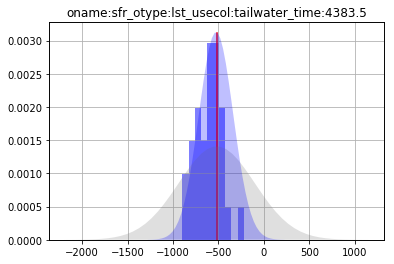

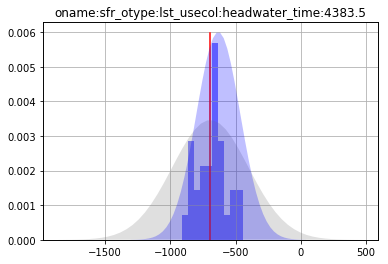

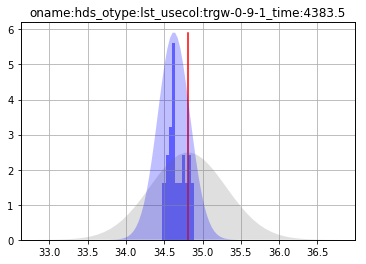

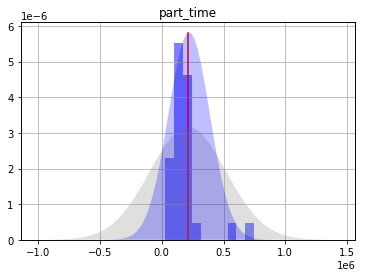

In [70]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    # plot Monte Carlo posterior
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,density=True)
    # plot truth
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    # plot FOSM prior
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    # plot FOSM posterior
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    #ax.set_xlim(oe_pt.loc[:,forecast].min() * .1,oe_pt.loc[:,forecast].max() * 1.5)
    #axt.set_xlim(oe_pt.loc[:,forecast].min() * .10,oe_pt.loc[:,forecast].max() * 1.5)
    ax.set_title(forecast)
    plt.show()

So, good news and bad news. 

The good news: the FOSM posterior (blue-shaded area) overlaps the Monte Carlo posterior (blue columns) for all forecasts. Good, the assumed linear parameter-forecast relation in the FOSM calculations seems to hold up - yeah! 

The bad news: some forecasts are not covered by either posterior. Dear oh dear - uncertainty analysis has failed! Why is this? Is it because of an imperfect model (often yes, but not in this case because our model is the same as our reality)? Is it because we are using too few parameters (in this case, yes, this is most likley the cause)? 

Now, here we have the luxury of knowing the "truth". In the real-world, we do not! We would not know that our forecast was wrong.

So how do we reduce the potential for misrepresenting forecast uncertainty? We return to this issue in the "freyberg pestpp-ies" and the "model error concepts" notebooks.

### xx. Final Remarks

In this tutorial we demonstrated the steps for deploying PEST++GLM for parallelized highly-parameterized inversion using `pyemu`. We discussed some common settings and options available in PEST++GLM and employed functionality available in `pyemu` to explore the outcomes of inversion. We noted some indicators of bias and/or structural error, however other tutorials delve into these topics in greater detail. 

We encourage readers to use this notebook to explore the effects of alternative PEST++GLM settings. The model is relatively fast and enables experimentation. Why not explore the implications of not using SVD-Assist? Or different observation weighting schemes? Or more/other parameters? What are the costs/benefits?